<img src='../img/joint_school_banner_2.png' alt='Training school and workshop on fire' align='center' width='100%'></img>

<br>

<hr>

# LSA SAF Fire Risk Map

### About

The LSA SAF <a href='https://landsaf.ipma.pt/en/products/fire-products/frmv2/' target='_blank'>Fire Risk Map v2 (FRMv2)</a> product "combines information from Numerical Weather Prediction (NWP) models - in this case the operational forecasts from ECMWF - and historical SEVIRI estimates of Fire Radiative Power to derive forecasts of the risk of fire. The rationale is to provide the user community with information on meteorological risk that will allow adopting the adequate measures to mitigate fire damage. The FRM algorithm computes the probability of a fires reaching very high intensities for the following 24h, 48h, ... 120h. These indicate prognostic levels of fire danger over Southern Europe and part of Northern Africa." <a href='https://landsaf.ipma.pt/en/products/fire-products/frmv2/' target='_blank'>(Source)</a>

This notebook shows the structure of `LSA SAF Fire Risk Map v2` (FRMv2) data and what information of the data files can be used in order to load, browse and visualize the data. 

The events featured in this notebook are the wildfires in Italy and Greece in summer 2021. 

### Basic Facts

> **Spatial resolution**: `3km`<br>
> **Spatial coverage**: `Mediterranean Europe` <br>
> **Time steps**: `Daily forecasts (24-hr up to 120-hr ahead)` <br>
> **Data availability**: `since 2017`


### How to access the data

The FRMv2 data can be ordered via <a href='https://landsaf.ipma.pt/en/products/fire-products/frmv2/' target='_blank'>LSA SAF</a> and are distributed in `HDF5` format, which is then compressed as a `TAR` file for download. 

You need to <a href='https://landsaf.ipma.pt/security/login.jsp?seltab=1' target='_blank'>register for an account</a> before being able to download data.

<hr>

##### Load required libraries

In [1]:
import os
from netCDF4 import Dataset
import xarray as xr
import datetime
import glob
import tarfile
import numpy as np
from datetime import datetime

from osgeo import gdal,osr
import pyproj

import bz2

# Python libraries for visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import BoundaryNorm, ListedColormap, TwoSlopeNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, clear_output

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id="load_frm"></a>1. Load and browse the LSA SAF Fire Risk Map v2 data

The fire risk map product consists of daily forecasts of classes of meteorological fire danger over Mediterranean Europe. Five fire risk classes are provided, ranging from low to extreme risk. The forecast timesteps available start at 24 hours to 120 hours. The dataset shown here is for the 24 hour forecast.

#### [OPTIONAL] Unzip the LSA SAF Fire Risk Map v2 data

LSA SAF Fire Risk Map v2 data are disseminated in the `HDF5` format which is compressed twice, first as a `bz2` file individually and then as a group as a `TAR` file. You can use the library [tarfile](https://docs.python.org/3/library/tarfile.html) to open and extract the files. This step is optional because we have already decompressed the file for you. This is why the code is commented out below.

In [3]:
# Open file
# tar = tarfile.open('../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116.tar')

# Extract file
# tar.extractall('../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116')
  
# tar.close()

When you look in the folder containing the extracted files, you will note that the files are compressed individually in `bz2` format. You can use `bunzip2`, which is part of the [bzip2](https://www.sourceware.org/bzip2/) library, to decompress the `bz2` files. You use the `-k` flag to indicate that you want to keep the `bz2` archive file and not replace it with the decompressed file. You use the `-f` flag to indicate that you want to replace any existing files with the same filename.

In [4]:
# %%bash

# bunzip2 -k -f '../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200.bz2'

#### Inspect structure of LSA SAF Fire Risk Map v2 product data files (24 hour timestep)

First, define the filepath for where the `hdf5` file(s) are located and store this as the variable `in_filepath`. You can also define the filepath for where the new `tif` file(s) will be placed, storing it as the variable `out_filepath`.

You can also inspect the files in the folder containing the `hdf5` files. As we specified a specific file which contains the 24 hour forecast, there should only be a single file in the list.

In [5]:
in_filepath = '../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200'
out_filepath = '../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116/'

myfiles = glob.glob(in_filepath)
myfiles

['../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200']

You can use the [gdal](https://gdal.org/) Python library to access and manipulate datasets in `HDF5` format. Next, you can use the for-loop defined below to process the `hdf5` files. There are several steps: 
- **Print file name**: The file name is printed out.
- **Modify file name**: The `.hdf` file ending is split off and a `.tif` ending is added. A second file is created with the `_rep.tif` ending; "rep" stands for reprojected.
- **Translate data**:The satellite height and elliptical values are translated to xy values in the new `.tif` file using the `gdal_translate` function. At this step we pass in the internal path to the fire risk data which is `://Risk`.
- **Warp data**: The values are mapped out and stored in the new `_rep.tif` file using `gdalwarp`.

In [15]:
for f in myfiles:
    filename = f.split("\\")[-1]
    print("filename:",filename,"\n")
    
    # Modify file name
    f_out = filename + ".tif"  
    print("f_out:",f_out,"\n")
    
    f_rep = filename + "_rep.tif" 
    print("f_rep:",f_rep,"\n")
    
    # Translate data
    os.system('gdal_translate -of GTiff -a_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -a_ullr  -5568748.27576  5568748.27576 5568748.27576 -5568748.27576 HDF5:'+ filename +'://Risk '+ f_out)
    
    # Warp data
    os.system('gdalwarp -ot Float32 -s_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -t_srs EPSG:4326 -r near -of GTiff ' + f_out + ' ' + f_rep)
   
print('done.')

filename: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200 

f_out: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200.tif 

f_rep: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_rep.tif 

Input file size is 3712, 3712
0...10...20...30...40...50...60...70...80...90...100 - done.


ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain


Creating output file that is 3879P x 3537L.
Processing ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
done.


Next, you can enable exceptions in the gdal library to be notified in case of a failure. Then you define the file path to the reprojected `tif` file and open it using `gdal.Open()`.

In [49]:
gdal.UseExceptions()

rep_file = '../../../eodata/lps_fire/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_rep.tif' 
ds = gdal.Open(rep_file)

You can take a look at some attributes from the reprojected `tif` file, such as the number of columns, rows, bands and the driver.

In [50]:
cols = ds.RasterXSize
print('The number of columns is ',cols)
rows = ds.RasterYSize
print('The number of rows is ', rows)
bands = ds.RasterCount
print('The number of bands is ', bands)
driver = ds.GetDriver().LongName
print('The driver is ', driver)

The number of columns is  3879
The number of rows is  3537
The number of bands is  1
The driver is  GeoTIFF


Next, you can access the metadata from the dataset using the gdal function `.GetMetadata()`. Then, print out the metadata to see what is available.

In [51]:
meta = ds.GetMetadata()
for i in meta: 
    print(i)

ARCHIVE_FACILITY
AREA_OR_POINT
ASSOCIATED_QUALITY_INFORMATION
CENTRE
CFAC
CLOUD_COVERAGE
COFF
COMPRESSION
DISPOSITION_FLAG
END_ORBIT_NUMBER
FIELD_TYPE
FORECAST_STEP
GRANULE_TYPE
IMAGE_ACQUISITION_TIME
INSTRUMENT_ID
INSTRUMENT_MODE
LFAC
LOFF
NB_PARAMETERS
NC
NL
NOMINAL_LAT
NOMINAL_LONG
NOMINAL_PRODUCT_TIME
ORBIT_TYPE
OVERALL_QUALITY_FLAG
PARENT_PRODUCT_NAME
PIXEL_SIZE
PROCESSING_LEVEL
PROCESSING_MODE
PRODUCT
PRODUCT_ACTUAL_SIZE
PRODUCT_ALGORITHM_VERSION
PRODUCT_TYPE
PROJECTION_NAME
REGION_NAME
SAF
SATELLITE
SENSING_END_TIME
SENSING_START_TIME
SPECTRAL_CHANNEL_ID
START_ORBIT_NUMBER
STATISTIC_TYPE
SUB_SATELLITE_POINT_END_LAT
SUB_SATELLITE_POINT_END_LON
SUB_SATELLITE_POINT_START_LAT
SUB_SATELLITE_POINT_START_LON
TIME_RANGE


You can extract the value of a metadata property by using `[]` square brackets and passing in the name of the property. Let's extract the `'PRODUCT'` metadata value.

In [52]:
product = meta['PRODUCT']
product

'FRM'

You can use these metadata properties in your final plot. For example, you can extract the date from `'IMAGE_ACQUISITION_TIME'`, turn it into a `datetime` object and then reformat it for use in your plot.

In [53]:
date = meta['IMAGE_ACQUISITION_TIME']
date

'20210805120000'

In [54]:
timestamp = datetime.strptime(date, '%Y%m%d%H%M%S')
timestamp

datetime.datetime(2021, 8, 5, 12, 0)

In [55]:
title_time = timestamp.strftime('%d %B %Y')
title_time

'05 August 2021'

## <a id="vis_frm"></a>2. Visualise the LSA SAF Fire Risk Map v2 data

To plot the data, you first need to read in the data as as numpy array, using the function `.ReadAsArray()`. Then you can mask out the data where the values are equal or less than the missing value of `-8000`. 

In [56]:
data = ds.ReadAsArray()
data = np.ma.masked_where(data <= -8000, data)

You can make use of the `ListedColorMap` function from the matplotlib library to define the colors for each fire risk class.

In [57]:
cmap = ListedColormap([[24/255., 148/255., 15/255.],
                      [255./255., 255./255., 0],
                      [1., 140./255., 0], [1, 0, 0],
                      [178./255., 34./255., 34./255.]])

You can define the levels for the respective fire risk classes in a list stored in the variable `bounds`. The fire risk data has a categorical range from 1 to 5, from low to extreme risk. You can also use the `.BoundaryNorm()` function from `matplotlib.colors` to define the norm that you will use for plotting later. 

In [58]:
bounds = [0,1.5,2.5,3.5,4.5,5.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)  

Finally, you can visualise the fire risk data by plotting it.

The plotting code can be divided in five main parts:
* **Define the coordinate reference system for the plot**
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, borders and a grid**: specify additional features to be added to the plot
* **Plotting function**: specify the extent and plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

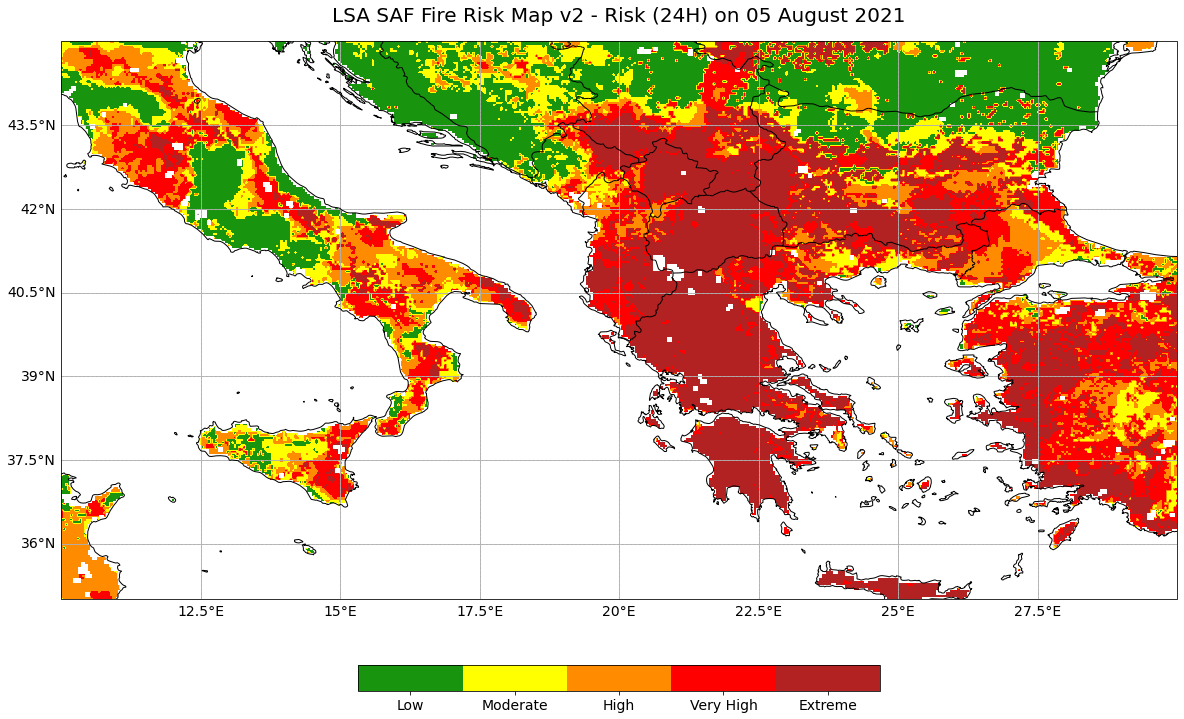

In [59]:
# Define the coordinate reference system
crs = ccrs.PlateCarree()

# Initiate a matplotlib figure
fig=plt.figure(figsize=(20, 12))
ax = plt.axes(projection=crs)

# Specify coastlines and borders
ax.coastlines(zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, zorder=3)

# Specify a grid
gl = ax.gridlines(crs=crs)
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Set extent of the plot to the Mediterranean 
ax.set_extent([10, 30, 35, 45])

# Define the image extent
img_extent = (-81.26765645410755,81.26765645410755,-74.11423113858775,74.11423113858775)

# Plot the data
cax = ax.imshow(data, cmap=cmap, origin='upper', extent=img_extent, transform=crs, norm=norm)

# Define the colorbar, tick locations and tick labels 
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1, ticks=[0.75,2,3,4,5])
cbar.ax.set_xticklabels(['Low','Moderate','High','Very High','Extreme'])
cbar.ax.tick_params(labelsize=14)

# Set the title of the plot
ax.set_title('LSA SAF Fire Risk Map v2 - Risk (24H) on ' + title_time, fontsize=20, pad=20.0)

# Show the plot
plt.show()

**Return to the chapter:**
- [Surface impacts of wildfires](./01_surface_intro.ipynb#lsasaf_frm)

## Probabilities of a Potential Wildfire exceeding 2000 GJ of Daily Energy released by Fires (P2000)

The P2000 dataset shows the probabilities of a potential wildfire exceeding 2000 GJ of daily energy released by fires. In other words, it provides information on the likelihood of a potential wildfire getting out of control.

## <a id="load_p2000"></a>3. Load and browse the LSA SAF P2000 data

You can reuse the variables `in_filepath` and `out_filepath` that you defined earlier.

You can use the [gdal](https://gdal.org/) Python library to access and manipulate datasets in `HDF5` format. Next, you can use the for-loop defined below to process the `hdf5` files. There are several steps: 
- **Print file name**: The file name is printed out.
- **Modify file name**: The `.hdf` file ending is split off and a `.tif` ending is added. A second file is created with the `_rep.tif` ending; "rep" stands for reprojected.
- **Translate data**:The satellite height and elliptical values are translated to xy values in the new `.tif` file using the `gdal_translate` function. At this step we pass in the internal path to the P2000 data which is `P2000`.
- **Warp data**: The values are mapped out and stored in the new `_rep.tif` file using `gdalwarp`.

In [45]:
for f in myfiles:
    
    # Print file name
    filename = f.split("\\")[-1]
    print("filename:",filename,"\n")
    
    # Modify file name
    f_out = filename +"_p2000" + ".tif"  
    print("f_out:",f_out,"\n")
    
    f_rep = filename +"_p2000" + "_rep.tif" 
    print("f_rep:",f_rep,"\n")
    
    # Translate data
    os.system('gdal_translate -of GTiff -a_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -a_ullr  -5568748.27576  5568748.27576 5568748.27576 -5568748.27576 HDF5:'+ filename +'://P2000 '+ f_out)
    
    # Warp data
    os.system('gdalwarp -ot Float32 -s_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -t_srs EPSG:4326 -r near -of GTiff ' + f_out + ' ' + f_rep)
   
print('done.')

filename: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200 

f_out: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000.tif 

f_rep: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000_rep.tif 

Input file size is 3712, 3712
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3879P x 3537L.
Processing ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000.tif [1/1] : 0

ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain


...10...20...30...40...50...60...70...80...90...100 - done.
done.


Next, define the file path to the reprojected `tif` file and open it using `gdal.Open()`.

In [74]:
p2000_file = '../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000_rep.tif'
p2000_ds = gdal.Open(p2000_file)

## <a id="vis_p2000"></a>4. Visualise the LSA SAF P2000 data

To plot the data, you first need to read in the data as as numpy array, using the function `.ReadAsArray()`. Then you can mask out the data where the values are equal or less than the missing value of `-8000`. 

In [75]:
p2000_data = p2000_ds.ReadAsArray()
p2000_data = np.ma.masked_where(p2000_data <= -8000, p2000_data)

Finally, you can visualise the fire risk data by plotting it.

The plotting code can be divided in five main parts:
* **Define the coordinate reference system for the plot**
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, borders and a grid**: specify additional features to be added to the plot
* **Plotting function**: specify the extent and plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

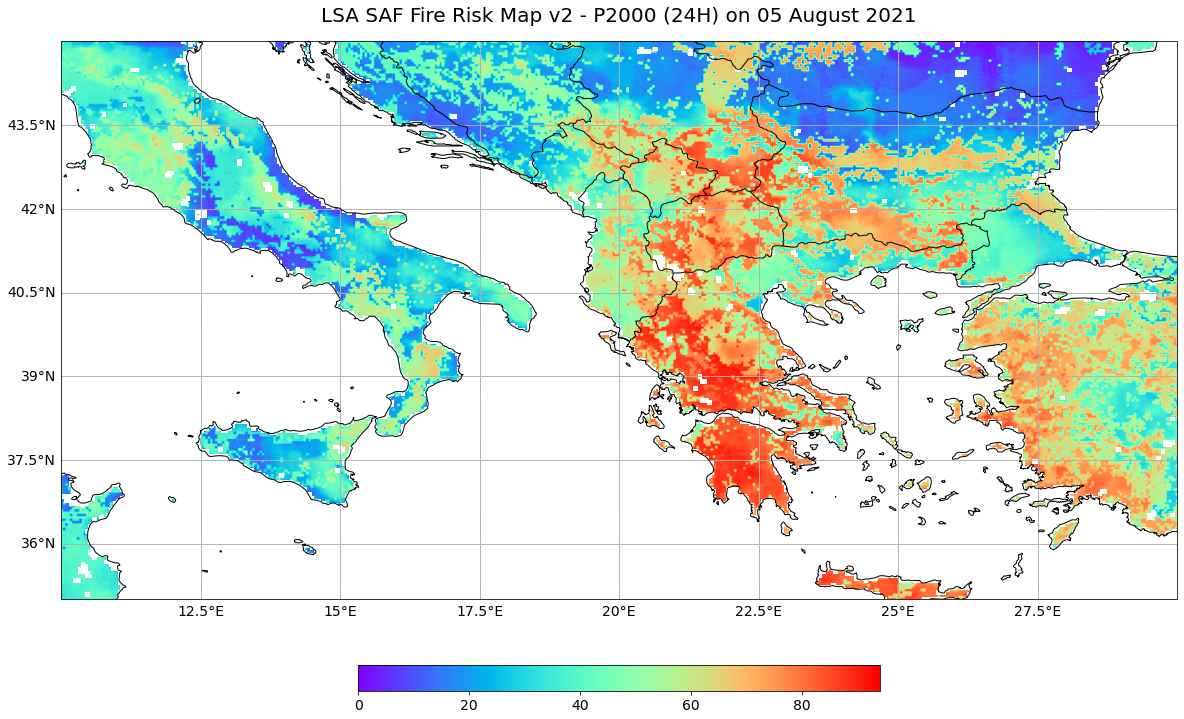

In [76]:
# Define the coordinate reference system
crs = ccrs.PlateCarree()

# Initiate a matplotlib figure
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=crs)

# Specify coastlines and borders
ax.coastlines(zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, zorder=3)

# Specify a grid
gl = ax.gridlines(crs=crs)
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Set extent of the plot to the Mediterranean 
ax.set_extent([10, 30, 35, 45])

# Define the image extent (the extent of the data)
img_extent = (-81.26765645410755,81.26765645410755,-74.11423113858775,74.11423113858775)

# Plot the data
cax = ax.imshow(p2000_data, cmap="rainbow", origin='upper', extent=img_extent, transform=crs)

# Define the colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.ax.tick_params(labelsize=14)

# Set the title of the plot
ax.set_title('LSA SAF Fire Risk Map v2 - P2000 (24H) on ' + title_time, fontsize=20, pad=20.0)

# Show the plot
plt.show()

**Return to the chapter:**
- [Surface impacts of wildfires](./01_surface_intro.ipynb#lsasaf_p2000)

## 24 hour forecast of the anomaly of probability of exceedance of 2000 GJ of daily energy released by fires (P2000a)

This anomaly is computed at each pixel as the deviation of the probability of exceedance for a given pixel and a given day of a given year from the average of all values of probability of exceedance for that pixel and day over the period 1979–2016.

## <a id="load_p2000a"></a>5. Load and browse the LSA SAF P2000a data

You can reuse the variables `in_filepath` and `out_filepath` that you defined earlier.

You can use the [gdal](https://gdal.org/) Python library to access and manipulate datasets in `HDF5` format. Next, you can use the for-loop defined below to process the `hdf5` files. There are several steps: 
- **Print file name**: The file name is printed out.
- **Modify file name**: The `.hdf` file ending is split off and a `.tif` ending is added. A second file is created with the `_rep.tif` ending; "rep" stands for reprojected.
- **Translate data**:The satellite height and elliptical values are translated to xy values in the new `.tif` file using the `gdal_translate` function. At this step we pass in the internal path to the P2000a data which is `P2000a`.
- **Warp data**: The values are mapped out and stored in the new `_rep.tif` file using `gdalwarp`.

In [63]:
for f in myfiles:
    
    # Print file name
    filename = f.split("\\")[-1]
    print("filename:",filename,"\n")
    
    # Modify file name
    f_out = filename +"_p2000a" + ".tif"
    print("f_out:",f_out,"\n")
    
    f_rep = filename +"_p2000a" + "_rep.tif" 
    print("f_rep:",f_rep,"\n")
    
    # Translate data
    os.system('gdal_translate -of GTiff -a_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -a_ullr  -5568748.27576  5568748.27576 5568748.27576 -5568748.27576 HDF5:'+ filename +'://P2000a '+ f_out)
    
    # Warp data
    os.system('gdalwarp -ot Float32 -s_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
    -t_srs EPSG:4326 -r near -of GTiff ' + f_out + ' ' + f_rep)
   
print('done.')

filename: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200 

f_out: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000a.tif 

f_rep: ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000a_rep.tif 

Input file size is 3712, 3712
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 3879P x 3537L.
Processing ../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000a.tif [1/1] : 0

ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain
ERROR 1: Point outside of projection domain


...10...20...30...40...50...60...70...80...90...100 - done.
done.


Next, define the file path to the reprojected `tif` file and open it using `gdal.Open()`.

In [77]:
p2000a_file = '../data/lsasaf/frmv2/2021/08/04/order_158116/HDF5_LSASAF_MSG_FRM-F024_MSG-Disk_202108051200_p2000a_rep.tif'
p2000a_ds = gdal.Open(p2000a_file)

## <a id="vis_p2000a"></a>6. Visualise the LSA SAF P2000a data

To plot the data, you first need to read in the data as as numpy array, using the function `.ReadAsArray()`. Then you can mask out the data where the values are equal or less than the missing value of `-8000`. 

In [78]:
p2000a_data = p2000a_ds.ReadAsArray()
p2000a_data = np.ma.masked_where(p2000a_data <= -8000, p2000a_data)

Finally, you can visualise the fire risk data by plotting it.

The plotting code can be divided in five main parts:
* **Define the coordinate reference system for the plot**
* **Initiate a matplotlib figure**: Initiate a matplotlib plot and define the size of the plot
* **Specify coastlines, borders and a grid**: specify additional features to be added to the plot
* **Plotting function**: specify the extent and plot the data with the plotting function `imshow()`
* **Set plot title**: specify title of the plot

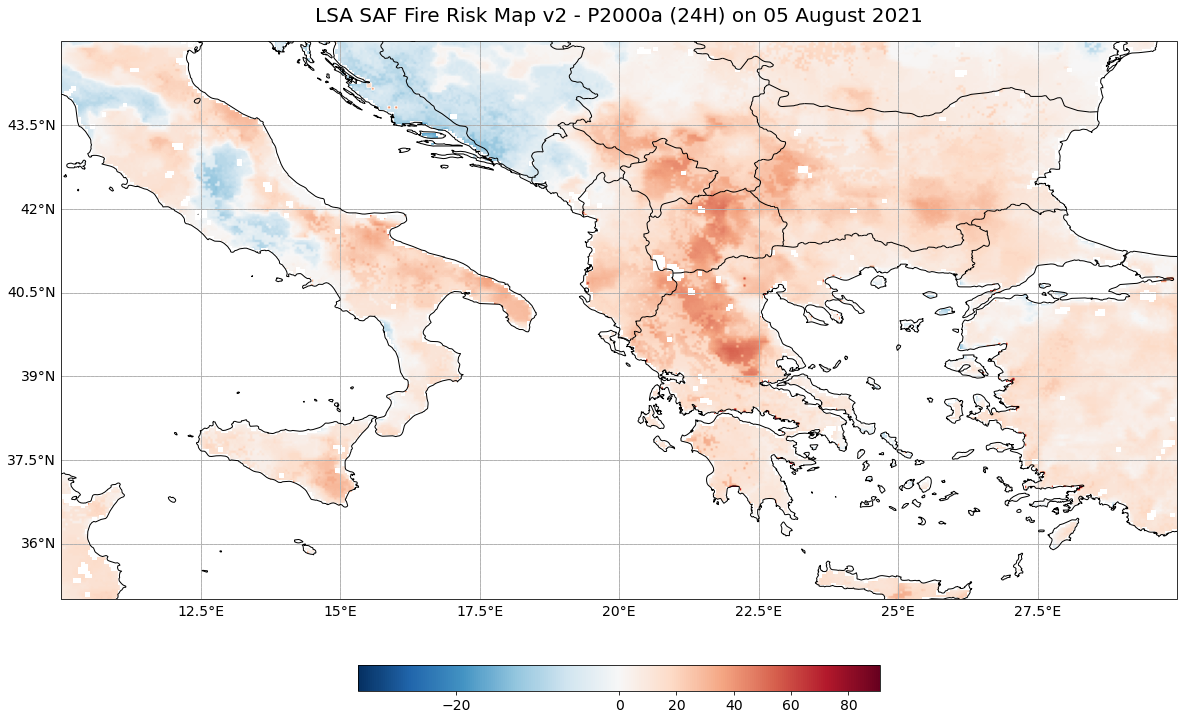

In [79]:
# Define the coordinate reference system
crs = ccrs.PlateCarree()

# Initiate a matplotlib figure
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection=crs)

# Specify coastlines and borders
ax.coastlines(zorder=3)
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, zorder=3)

# Specify a grid
gl = ax.gridlines(crs=crs)
gl = ax.gridlines(draw_labels=True, linestyle='--')
gl.top_labels=False
gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

# Set extent of the plot to the Mediterranean 
ax.set_extent([10, 30, 35, 45]) # Mediterranean

# Define the image extent (the extent of the data)
img_extent = (-81.26765645410755,81.26765645410755,-74.11423113858775,74.11423113858775)

# Center white part of color ramp on 0
norm = TwoSlopeNorm(vmin=p2000a_data.min(), vcenter=0, vmax=p2000a_data.max())

# Plot the data
cax = ax.imshow(p2000a_data, cmap="RdBu_r", norm=norm, origin='upper', extent=img_extent, transform=crs)

# Define the colorbar
cbar = fig.colorbar(cax, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.ax.tick_params(labelsize=14)

# Set the title of the plot
ax.set_title('LSA SAF Fire Risk Map v2 - P2000a (24H) on ' + title_time, fontsize=20, pad=20.0)

# Show the plot
plt.show()

**Return to the chapter:**
- [Surface impacts of wildfires](./01_surface_intro.ipynb#lsasaf_p2000a)

<hr>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.